# DenseNet Model - Tyler Bryk

In this notebook, we will write a Python script which uses a convolutional neural network (CNN) to classify the make, model, and year of a vehicle given its raw jpeg image. The CNN will be modeled by a DenseNet-121 using PyTorch’s deep learning library. The workflow for this notebook will be as follows: 

1. Load and Transofrm the Data

2. Define a DenseNet Model and Parameters

3. Train the Model

4. Calculate the In and Out-of-Sample Accuracies

5. Tune the Model Hyperprameters and Re-evaluate

6. Save the Trained Model to a PyTorch .pth File

7. Define Functions to Process and Display Images

8. Define Functions to Predict Class of New Images

First, we will import the required dependencies; and then gather the data from Google Drive. Originally, this notebook was intended to be scripted using a local Jupyter notebook, however, due to the computational expense, a dedicated Microsoft AzureML compute was spun up to store and run the notebook. This notebook is GPU accelerated with a Nvidia Tesla K80 GPU; and all required dependencies / data are stored on the cloud server.

In [1]:
# Load Dependencies
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

In [2]:
# Locate Stanford Data
from google.colab import drive
drive.mount('/content/drive')
trainDir = '/content/drive/My Drive/StanfordData/train'
testDir  = '/content/drive/My Drive/StanfordData/test'

**1. Loading & Transforming the Data**

In the following module, we will load the [Stanford dataset](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder), and normalize the data. We will use PyTorch's [Torchvision Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) library to apply transforms on the dataset, [Torchvision datasets.ImageFolder()](https://pytorch.org/docs/stable/torchvision/datasets.html) and [Torchvision util.data.DataLoader()](https://pytorch.org/docs/stable/data.html) to load the raw jpeg images into a library. First, we will create a simple transform which resizes all of the images to a standard size (256x256), converts the image to a tensor object, and then normalizes each tensor object. The normalization values are in the format of (mean[ch1], mean[ch2], mean[ch3]) and (std[ch1], std[ch2], std[ch3]). In this initial step, the mean and standard deviation values are initialized based on the recommended values from PyTorch. Next, the ImageFolder() method is called with the DataLoader() to open each of the transformed images and load them into a single training or testing library. 

In [3]:
# Data Transform
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),
                                                     (0.229, 0.224, 0.225) )])

# Create Training and Testing Set from Transforms
trainData = datasets.ImageFolder(trainDir, transform=transform)
testData  = datasets.ImageFolder(testDir,  transform=transform)

# Load Image Files into a Library
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=128, shuffle=True)
testLoader  = torch.utils.data.DataLoader(testData,  batch_size=32,  shuffle=True)

**2. Defining the Resnet Model and Parameters**

In this step, we will build a Dense Convolutional Neural Network (DenseNet) using PyTorch's [DenseNet model](https://pytorch.org/hub/pytorch_vision_densenet/). The DenseNet is a type of deep convolutional neural network which comes in many flavors based on the desired input size and number of hidden layers. Additionally, the DenseNet comes either as a standalone model, or a pre-trained model which is trained on the [ImageNet Database](http://www.image-net.org). In our application, we will select the pre-trained model with 121 layers. Selecting the pre-trained variant will help us achieve better model generalization to new data, meaning that the model should repsond well to our raw training data. After initializing the model, we then use PyTorch's [nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to apply a linear tranform to the fully-connected (fc) layers based on the input size of the images, and the number of classes which is 196. Next, we will set the models scoring criterion to follow a cross-entropy loss function, using PyTorch's [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function. We then define the optimizing method as PyTorch's [optim.SGD()](https://pytorch.org/docs/stable/optim.html). Although PyTorch offers a wide variety of optimzers, we will choose SGD for now because of its simplicity. Additionally, we will arbitrarily select a learning rate of 0.01 and momentum of 0.9, these parameters can be tuned in a later step. For now, PyTorch offers a learning rate scheduler as part of the [optim library](https://pytorch.org/docs/stable/optim.html), so we will use that function to reduce the learning rate once our parameters have stopped improving. This function will take our SGD optimizer and observe the number of epochs where the model improves, the patience flag will allow the model to remain constant for 3 epochs before enagaging, and the threshold flag defines the amount of variance to be considered when evaluating the epochs.

In [4]:
# Deep Residual Network Model
dnet = models.densenet121(pretrained=True)
dnet.classifier = nn.Linear(1024, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dnet.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

**3. Training the Model**

Now that the model is defined, we will begin training it by using the Nvidia Cuda processor. For this application, a Nvidia Tesla K80 GPU accelerator is being used through Microsoft AzureML. The GPU accelerator will greatly increase the efficiency of the model which will expedite the training process. First, we set the processor to point to our GPU, and then we set the model to training mode. Then, for 10 epochs (epoch tuning will be done in a later step) we run through the training data and calculate the loss using SGD. The training loss at each epoch is displayed in the results. Overall, the loss exponentially decreases, and it ultimately converges at a relatively small number. 

In [5]:
epochs = 10
steps = 0

dnet.to('cuda')
dnet.train()
for epoch in range(epochs):
    runningLoss = 0
    
    # Iterate over Training Data
    for step, (inputs, labels) in enumerate(trainLoader):
        steps += 1
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()                 # Set Param Gradients to Zero
        outputs = dnet.forward(inputs)        # Feed-forward Pass
        loss = criterion(outputs, labels)     # Calculate Loss
        loss.backward()                       # Backpropagation Pass
        optimizer.step()                      # Update Parameters
        runningLoss += loss.item()            # Update Total Loss
        
    print(f"No. epochs: {epoch+1}, Training Loss: {round(runningLoss/100,3)}")

No. epochs: 1, Training Loss: 3.101
No. epochs: 2, Training Loss: 1.864
No. epochs: 3, Training Loss: 0.954
No. epochs: 4, Training Loss: 0.463
No. epochs: 5, Training Loss: 0.217
No. epochs: 6, Training Loss: 0.102
No. epochs: 7, Training Loss: 0.056
No. epochs: 8, Training Loss: 0.036
No. epochs: 9, Training Loss: 0.025
No. epochs: 10, Training Loss: 0.02


**4. Calculating In and Out-of-Sample Accuracies**

With training complete, we can now turn off the gradient calculations and run through both the training and testing data to calculate the performance. We run through both datasets and record the percentage of correct classifications. As the results show, the training accuracy is very high, and the testing accuracy is acceptable, but very overfit when compared to the training accuracy. In the next step we will tune the model hyperparameters to try and reduce the overfitting. 

In [6]:
correct = 0
total = 0

dnet.to('cuda')
with torch.no_grad():
    for data in trainLoader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = dnet(images)
        _, prediction = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

print(f"Training Accuracy: {round(100*correct/total,3)}%")

Training Accuracy: 99.84%


In [7]:
correct = 0
total = 0

dnet.to('cuda')
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = dnet(images)
        _, prediction = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (prediction == labels).sum().item()

print(f"Test Accuracy: {round(100*correct/total,3)}%")

Test Accuracy: 78.821%


**5. Tune Model Hyperparameters**

In an effort to simplify this document, the code sections for tuning the models hyperparameters will be omitted, and instead, we will use this section to discuss some of the tuning implementations that occurred. When tuning a model, there are a lot of different techniques that can be applied from manipulating the training data with pre-processing to adjusting the model parameters. As far as modifying the dataset goes, both the training and testing datasets were already balanced, so the most we can do is apply different transformations. After trial and error with different transformations such as center cropping, padding, and random filtering, it was concluded that the best accuracy was achieved with a simple resize and image normalization. As such, these are the only two transforms that were called in section 1, above. For the normalization means and standard deviations, two approaches were trialed. First, a generic mean of 0.5 and std. of 0.25 was trialed. Then, a second trial was conducted where the PyTorch suggested mean and std. was used for each channel. The results showed that using PyTorch’s mean and std. were optimal.  

In terms of model tuning, a few different parameters were varied which included the model complexity, number of training iterations, learning rate, and momentum. The PyTorch DenseNet model comes in a few different flavors: 121-layer, 161-layer, 169-layer, and 201-layer architectures. The DenseNet also comes with the option of being pre-trained. For the model architecture, the 121-layer version was initially chosen, and that ultimately ended up performing the best. The higher-layer models were trained, the 161 and 169-layer models yielded accuracies that were near identical to that of the 121-layer, but the model complexity was large, and the training time was very costly. The 201-layer version of the model was simply to large for our computer and resulted in a CUDA out of memory error. When testing the models as pretrained, having that flag set to ‘true’ yielded nearly an 6% testing accuracy boost in all cases, so that flag was left on for the remainder of the tuning process. Next, the model was tuned for a varying number of iterations ranging from 5 to 15. The result indicated that the model converged around 10 iterations, and diminishing returns were achieved afterwards. Lastly, the learning rate and momentum parameters were varied from 0.001 to 0.5, and 0.80 to 0.95, respectively. Ultimately, the optimal parameters were determined to be lr=0.01 and momentum=0.90. At this point, the model tuning was considered to be completed. 

It is important to note that training on this model took anywhere from 8 to 10 hours based on the parameters, so tuning the model was quite time extensive, this resulted in only a limited number of parameters being tuned. 

**6. Saving Trained Model**

Here, we will save the state dictionary, model structure, index-to-class mappings, state of the optimizer, and number of epochs into a PyToroch .pth file. This file can later be used to load the model and use it for testing and prediction making. This step is very critical because it allows us to save the model, reset our GPU processor to free up memory, and then pick up where we left off. The loadCheckpoint function loads our saved model and then we can enable parallel processing to speed up th efficiency during testing.

In [8]:
# Save Model and Parameters
checkpoint = {'state_dict': dnet.state_dict(),
              'model': dnet.classifier,
              'class_to_idx': trainData.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs
             }
torch.save(checkpoint, 'densenet121.pth')

In [9]:
def loadCheckpoint(model, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    return model

In [10]:
# Load Resnet Model and Start Parallel Processing
model = loadCheckpoint(dnet, 'densenet121.pth')
model = torch.nn.DataParallel(model)

**7. Defining Functions to Process / Display Images**

These helper functions can be used to load a selected image from the dataset. The processImage function loads the PIL Image and then applies the normalization tranforms to it, returning a numpy array containing the image vectors. The imshow function extends the built-in function from matplotlib, instead, our custom one reverses the image transforms and clips the image from 0 to 1 (clipping removes noise from the image). 

In [11]:
def processImage(image):
    pilImg = Image.open(image)
    transform = transforms.Compose([transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    return np.array(transform(pilImg))

In [12]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    image = np.clip(image, 0, 1)    
    ax.imshow(image)
    return ax

**8. Defining Functions to Predict on New Images**

Here, we write a function to make predictions on a new image given our model and the image. To save on memory, we load the model in CPU mode, using our local computers CPU, then we load the image into a tensor array and unsqueeze it. The model is then set to evaluation mode and the gradient calculations are turned off. We can now calculate the probabilities of the top 'k' classes where k=5. This function will return the liklihood of the image belonging to any one of the top 5 classes. Next, the plotSolution function takes these probabilities and displays them in a matplot to help with visualizing. 

In [13]:
def predict(image_path, model, topk=5): 
    loadedModel = loadCheckpoint(dnet, model).cpu()
    
    img = processImage(image_path)
    imgTensor = torch.from_numpy(img).type(torch.FloatTensor)
    imgAddDim = imgTensor.unsqueeze_(0)

    loadedModel.eval()
    with torch.no_grad():
        output = loadedModel.forward(imgAddDim)
          
    probsTop = output.topk(topk)[0]
    predictedTop = output.topk(topk)[1]

    conf = np.array(probsTop)[0]
    predicted = np.array(predictedTop)[0]
    return conf, predicted

In [14]:
def plotSolution(carname, model, topk=5):
    image_path = testDir + '/' + carname
    conf0, predicted0 = predict(image_path, model, topk=5)

    names = []
    for i in range(5):
        names += [classes[predicted0[i]]]

    image = Image.open(image_path)
    f, ax = plt.subplots(2,figsize = (6,10))
    ax[0].imshow(image)
    ax[0].set_title(carname)
    y_names = np.arange(len(names))
    ax[1].barh(y_names, conf0/conf0.sum(), color='red')
    ax[1].set_yticks(y_names)
    ax[1].set_yticklabels(names)
    ax[1].invert_yaxis() 
    plt.show()

In [15]:
def findClasses(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = findClasses(testDir)

**9. Predicting on New Images**

Finally, we are able to give our resnet model some new images and visualize the accuracy.

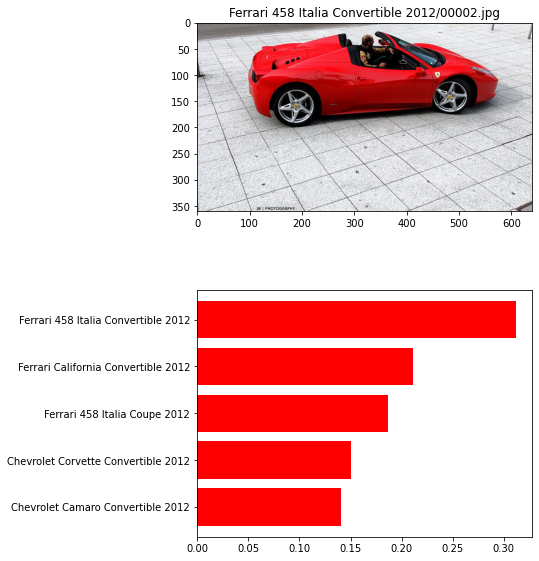

In [16]:
carname = 'Ferrari 458 Italia Convertible 2012/00002.jpg'
plotSolution(carname, 'densenet121.pth', 5)

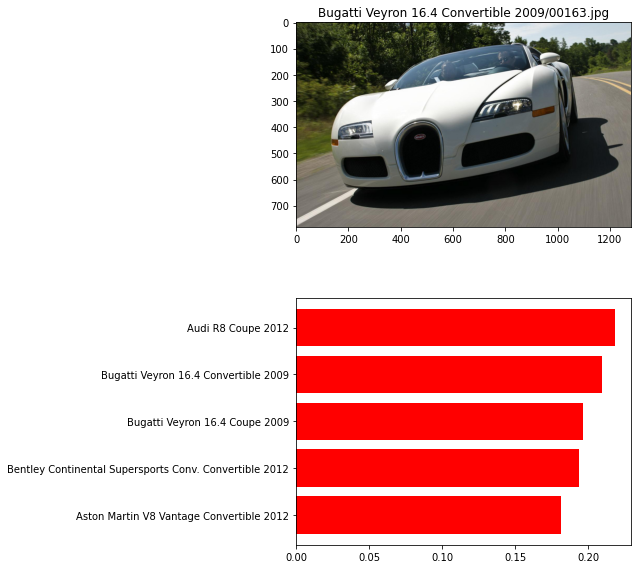

In [17]:
carname = 'Bugatti Veyron 16.4 Convertible 2009/00163.jpg'
plotSolution(carname, 'densenet121.pth', 5)

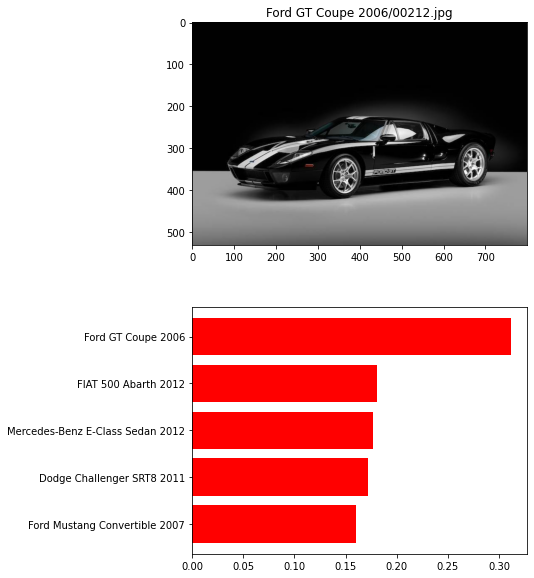

In [18]:
carname = 'Ford GT Coupe 2006/00212.jpg'
plotSolution(carname, 'densenet121.pth', 5)